### Tallest Buildings - population
first data cleaning

In [1]:
import pandas as pd

In [2]:
# note - went in and replaced "sao paulo" entries due to encoding annoyances
xl = pd.ExcelFile('raw_data/(778114242) buildings_2016-03-10-21-20-21.xlsx')

In [3]:
DFs = []
DFs.append(xl.parse(xl.sheet_names[0], skiprows=1,
                    parse_cols=[0, 3, 8, 10, 12, 15, 18, 20, 24], convert_float=False,
                 names=['Rank', 'Building', 'City', 'Height_m', 'Height_ft', 'Floors', 
                        'DateComplete', 'Material', 'Use']))
for sheet in xl.sheet_names[1:]:
    DFs.append(xl.parse(sheet, parse_cols=[0, 2, 3, 4, 5, 6, 7, 8, 9], convert_float=False,
                 names=['Rank', 'Building', 'City', 'Height_m', 'Height_ft', 'Floors', 
                        'DateComplete', 'Material', 'Use']))
    
df = pd.concat(DFs)
# make dataframe's index unique
df.reset_index(inplace=True) 
df.drop('index', inplace=True, axis=1)

In [4]:
df.head()

,Rank,Building,City,Height_m,Height_ft,Floors,DateComplete,Material,Use
0,1,Burj Khalifa,Dubai,828.0,"2,717",163,2010,steel/concrete,office / residential /\nhotel
1,2,Shanghai Tower,Shanghai,632.0,"2,073",128,2015,composite,hotel / office
2,3,Makkah Royal C lock Tower,Mecca,601.0,"1,972",120,2012,steel/concrete,other / hotel
3,4,One World Trade C enter,New York C ity,541.3,"1,776",94,2014,composite,office
4,5,TAIPEI 101,Taipei,508.0,"1,667",101,2004,composite,office


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3358 entries, 0 to 3357
Data columns (total 9 columns):
Rank            3358 non-null float64
Building        3358 non-null object
City            3358 non-null object
Height_m        3358 non-null float64
Height_ft       3358 non-null object
Floors          3358 non-null object
DateComplete    3358 non-null float64
Material        2573 non-null object
Use             3342 non-null object
dtypes: float64(3), object(6)
memory usage: 262.3+ KB


In [6]:
# write out full buildings dataset
df.to_csv('interim_data/buildings_raw.csv', index=False, index_label=False, encoding='UTF-8')

#### geocode buildings to use distance from city center
both as (1) selection between cities with same name (b/c buildings dataset doesn't have country) and (2) distance gradient of buildings' height from city center

# SKIP - buildings do not geocode well
need either more complete addresses or to scrape The Skyscraper Center's website

In [24]:
# get geographic coordinates of building
import geocoder

In [180]:
# at least 1 building (in Brisbane) does not have a name, so force it to be type string
# getting errors, put in loop so at least some get calculated and can fill in errors...
#df['geoCoord'] = df.apply(lambda x: geocoder.osm(str(x['Name'])+','+str(x['City'])).latlng, axis=1)
# initialize columns
df['lat'] = 0. 
df['lon'] = 0.
for i, row in df.iterrows():
    Bldg = row['Building'][0:row['Building'].find(u'\u2026')] if type(row['Building'])!=float else str(row['Building'])
    # try OSM geocoder first
    res = geocoder.osm(Bldg+', '+str(row['City'])).latlng
    if len(res)==2:
        df.loc[i, 'lat'] = res[0]
        df.loc[i, 'lon'] = res[1]
    else:
        # if doesn't work try google
        res = geocoder.google(Bldg+', '+str(row['City'])).latlng
        if len(res)==2:
            df.loc[i, 'lat'] = res[0]
            df.loc[i, 'lon'] = res[1]
    #print row.Rank, Bldg+','+str(row['City'])

In [181]:
df.head()

,Rank,Building,City,Height_m,Height_ft,Floors,DateComplete,Material,Use,city_ns,lat,lon
0,1,Burj Khalifa,Dubai,828.0,"2,717",163,2010,steel/concrete,office / residential /\nhotel,dubai,25.195125,55.275305
1,2,Shanghai Tower,Shanghai,632.0,"2,073",128,2015,composite,hotel / office,shanghai,31.230000,121.449000
2,3,Makkah Royal C lock Tower,Mecca,601.0,"1,972",120,2012,steel/concrete,other / hotel,mecca,21.389082,39.857912
3,4,One World Trade C enter,New York C ity,541.3,"1,776",94,2014,composite,office,newyorkcity,40.712949,-74.013161
4,5,TAIPEI 101,Taipei,508.0,"1,667",101,2004,composite,office,taipei,25.037517,121.563700


In [183]:
len(df[(df.lat==0) & (df.lon==0)])

832

In [184]:
# see if can geocode remaining 832 buildings
for i, row in df.iterrows():
    if (row.lat==0) & (row.lon==0):
        res = geocoder.google(row['Building']+', '+str(row['City'])).latlng
        if len(res)==2:
            df.loc[i, 'lat'] = res[0]
            df.loc[i, 'lon'] = res[1]
        else:
            res = geocoder.google(row['Building']+', '+str(row['city_ns'])).latlng
            if len(res)==2:
                df.loc[i, 'lat'] = res[0]
                df.loc[i, 'lon'] = res[1]

In [185]:
len(df[(df.lat==0) & (df.lon==0)])

828

In [186]:
df[(df.lat==0) & (df.lon==0)].head()

,Rank,Building,City,Height_m,Height_ft,Floors,DateComplete,Material,Use,city_ns,lat,lon
40,41,Wuxi International Finance Square,Wuxi,339.0,"1,112",68,2014,composite,hotel / office,wuxi,0,0
41,42,C hongqing World Financial C enter,C hongqing,338.9,"1,112",72,2015,composite,office,chongqing,0,0
51,52,Wuxi Suning Plaza 1,Wuxi,328.0,"1,076",67,2014,composite,hotel / serviced apartments / office,wuxi,0,0
72,73,The Franklin - North Tower,C hicago,306.9,"1,007",60,1989,composite,office,chicago,0,0
74,75,One57,New York C ity,306.1,"1,004",75,2014,steel/concrete,residential / hotel,newyorkcity,0,0


In [189]:
#geocoder.google('The Franklin North Tower, Chicago').latlng
geocoder.google('One 57, New York City').latlng

[]

In [190]:
# interim dataset v1 - with geocoding attempted
df.to_csv('interim_data/buildings_geocoded_v1.csv', index=False, index_label=False, encoding='UTF-8')

#### cities from Geonames database
http://download.geonames.org/export/dump/

In [8]:
# read in city location data (from geonames)
cities = pd.read_table('raw_data/cities15000.txt', header=None, 
                       names=['geonameid', 'name', 'asciiname', 'alternatenames', 'city_lat', 'city_lon', 'f_class',
                              'f_code', 'country_code','cc2', 'admin1', 'admin2', 'admin3', 'admin4', 'population', 
                              'elevation', 'dem', 'timezone', 'mod_date'])

cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23018 entries, 0 to 23017
Data columns (total 19 columns):
geonameid         23018 non-null int64
name              23018 non-null object
asciiname         23018 non-null object
alternatenames    20350 non-null object
city_lat          23018 non-null float64
city_lon          23018 non-null float64
f_class           23018 non-null object
f_code            23018 non-null object
country_code      23005 non-null object
cc2               250 non-null object
admin1            23011 non-null object
admin2            14301 non-null object
admin3            4875 non-null object
admin4            1916 non-null object
population        23018 non-null int64
elevation         3509 non-null float64
dem               23018 non-null int64
timezone          23018 non-null object
mod_date          23018 non-null object
dtypes: float64(3), int64(3), object(13)
memory usage: 3.5+ MB


In [11]:
# for population density estimates
import geopandas as gpd

In [12]:
cities_PD = gpd.read_file('interim_data/city_popdens.geojson')

In [13]:
print cities_PD.columns.tolist()

[u'field_1', u'field_10', u'field_11', u'field_12', u'field_13', u'field_14', u'field_15', u'field_16', u'field_17', u'field_18', u'field_19', u'field_2', u'field_3', u'field_4', u'field_5', u'field_6', u'field_7', u'field_8', u'field_9', 'geometry', u'glds00ag']


In [14]:
cols = dict(zip(cities_PD.columns.tolist(), ['geonameid', 'name', 'asciiname', 'alternatenames','city_lat', 'city_lon', 'f_class', 'f_code',
 'country_code','cc2', 'admin1', 'admin2', 'admin3', 'admin4', 'population', 'elevation', 'dem', 
 'timezone', 'mod_date', 'geometry', 'popdens']))
print cols

{u'field_8': 'timezone', u'field_6': 'elevation', u'field_9': 'mod_date', 'geometry': 'geometry', u'glds00ag': 'popdens', u'field_10': 'name', u'field_11': 'asciiname', u'field_12': 'alternatenames', u'field_13': 'city_lat', u'field_14': 'city_lon', u'field_15': 'f_class', u'field_16': 'f_code', u'field_17': 'country_code', u'field_18': 'cc2', u'field_19': 'admin1', u'field_4': 'admin4', u'field_5': 'population', u'field_2': 'admin2', u'field_3': 'admin3', u'field_7': 'dem', u'field_1': 'geonameid'}


In [15]:
cities_PD.rename(columns=cols, inplace=True)
cities_PD.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22970 entries, 0 to 22969
Data columns (total 21 columns):
geonameid         22970 non-null int64
name              249 non-null object
asciiname         22963 non-null object
alternatenames    14324 non-null object
city_lat          4868 non-null object
city_lon          1916 non-null object
f_class           22970 non-null int64
f_code            3486 non-null object
country_code      22970 non-null int64
cc2               22970 non-null object
admin1            22970 non-null object
admin2            22970 non-null object
admin3            22970 non-null object
admin4            20302 non-null object
population        22970 non-null float64
elevation         22970 non-null float64
dem               22970 non-null object
timezone          22970 non-null object
mod_date          22970 non-null object
geometry          22970 non-null object
popdens           22961 non-null float64
dtypes: float64(3), int64(3), object(15)
memory 

In [16]:
cities = pd.merge(cities, cities_PD.loc[:,('geonameid', 'popdens')], left_on='geonameid', right_on='geonameid')
cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22970 entries, 0 to 22969
Data columns (total 20 columns):
geonameid         22970 non-null int64
name              22970 non-null object
asciiname         22970 non-null object
alternatenames    20302 non-null object
city_lat          22970 non-null float64
city_lon          22970 non-null float64
f_class           22970 non-null object
f_code            22970 non-null object
country_code      22957 non-null object
cc2               249 non-null object
admin1            22963 non-null object
admin2            14266 non-null object
admin3            4868 non-null object
admin4            1916 non-null object
population        22970 non-null int64
elevation         3486 non-null float64
dem               22970 non-null int64
timezone          22970 non-null object
mod_date          22970 non-null object
popdens           22961 non-null float64
dtypes: float64(4), int64(3), object(13)
memory usage: 3.7+ MB


In [17]:
# create lower-case, no space columns for data join
df['city_ns'] = df.City.apply(lambda x: x.replace(" ", "").lower())
cities['city_ns'] = cities.asciiname.apply(lambda x: x.replace(" ", "").lower())

In [18]:
# merge on stripped down city names
df_full = pd.merge(df, cities.loc[:,('name', 'city_lat', 'city_lon', 'country_code', 'population', 
                                     'dem', 'timezone', 'city_ns', 'popdens')], 
                   how='outer', left_on='city_ns', right_on='city_ns')
df_full = df_full[~df_full.Building.isnull()]
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3721 entries, 0 to 3720
Data columns (total 18 columns):
Rank            3721 non-null float64
Building        3721 non-null object
City            3721 non-null object
Height_m        3721 non-null float64
Height_ft       3721 non-null object
Floors          3721 non-null object
DateComplete    3721 non-null float64
Material        2879 non-null object
Use             3705 non-null object
city_ns         3721 non-null object
name            3542 non-null object
city_lat        3542 non-null float64
city_lon        3542 non-null float64
country_code    3542 non-null object
population      3542 non-null float64
dem             3542 non-null float64
timezone        3542 non-null object
popdens         3542 non-null float64
dtypes: float64(8), object(10)
memory usage: 552.3+ KB


In [254]:
# Haversine formula example in Python: https://gist.github.com/rochacbruno/2883505
# Author: Wayne Dyck

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [255]:
# only useful after geocoding
#df_full['dist_to_city'] = df_full.apply(lambda r: distance((r.lat, r.lon), (r.city_lat, r.city_lon)), axis=1)

In [19]:
# WITH GEOCODING sort rows by building and distance then descending population
# df_full.sort_values(['Building', 'dist_to_city', 'population'], ascending=[True, True, False], inplace=True)

# WITHOUT GEOCODING, remove distance parameter
df_full.sort_values(['Building', 'population'], ascending=[True, False], inplace=True)
df_full = df_full[~df_full.duplicated(['Rank', 'Building', 'City', 'Height_m', 'Height_ft','Floors', 
                                       'DateComplete', 'Material', 'Use'])]

In [20]:
df_full.head()

,Rank,Building,City,Height_m,Height_ft,Floors,DateComplete,Material,Use,city_ns,name,city_lat,city_lon,country_code,population,dem,timezone,popdens
2893,292,0,Brisbane,249.0,817,81,2014,concrete,residential,brisbane,Brisbane,-27.46794,153.02809,AU,2189878,27,Australia/Brisbane,2875.931
871,1368,#1 Zhujiang Road Plaza,Nanjing,186.1,611,53,2007,NaN,office / hotel / retail,nanjing,Nanjing,32.06167,118.77778,CN,7165292,22,Asia/Shanghai,1789.877
470,3212,1 Battery Park Plaza,New York C ity,151.0,495,35,1971,NaN,office,newyorkcity,New York City,40.71427,-74.00597,US,8175133,57,America/New_York,14486.260
426,2330,1 Brooklyn Bridge Plaza,New York C ity,164.9,541,42,1976,NaN,office,newyorkcity,New York City,40.71427,-74.00597,US,8175133,57,America/New_York,14486.260
343,1148,1 Dag Hammarskjold Plaza,New York C ity,194.2,637,48,1972,NaN,office,newyorkcity,New York City,40.71427,-74.00597,US,8175133,57,America/New_York,14486.260


In [21]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 2893 to 1877
Data columns (total 18 columns):
Rank            3356 non-null float64
Building        3356 non-null object
City            3356 non-null object
Height_m        3356 non-null float64
Height_ft       3356 non-null object
Floors          3356 non-null object
DateComplete    3356 non-null float64
Material        2572 non-null object
Use             3340 non-null object
city_ns         3356 non-null object
name            3177 non-null object
city_lat        3177 non-null float64
city_lon        3177 non-null float64
country_code    3177 non-null object
population      3177 non-null float64
dem             3177 non-null float64
timezone        3177 non-null object
popdens         3177 non-null float64
dtypes: float64(8), object(10)
memory usage: 498.2+ KB


In [198]:
# buildings of which rank do not have associated pop values
print df_full[df_full.population.isnull()].Rank.describe()

count     122.000000
mean     1572.860656
std       930.895750
min        85.000000
25%       715.000000
50%      1566.500000
75%      2403.750000
max      3329.000000
Name: Rank, dtype: float64


In [258]:
# select out subset of maybe useful columns and drop records that have missing data
df_v1 = df_full.loc[:,('Rank', 'Building', 'name', 'Height_m', 'Floors', 'city_lat', 'city_lon', 'lat', 'lon',
                      'population', 'dem', 'dist_to_city', 'popdens')].dropna()
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177 entries, 2893 to 1877
Data columns (total 13 columns):
Rank            3177 non-null float64
Building        3177 non-null object
name            3177 non-null object
Height_m        3177 non-null float64
Floors          3177 non-null object
city_lat        3177 non-null float64
city_lon        3177 non-null float64
lat             3177 non-null float64
lon             3177 non-null float64
population      3177 non-null float64
dem             3177 non-null float64
dist_to_city    3177 non-null float64
popdens         3177 non-null float64
dtypes: float64(10), object(3)
memory usage: 347.5+ KB


In [259]:
# dataset to use
df_v1.to_csv('interim_data/tall_buildings_DB_v0328_withPopDens.csv', index=False, index_label=False, encoding='UTF-8')

#### some plots

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', font_scale=1.5)
%matplotlib inline

(-1, 25)

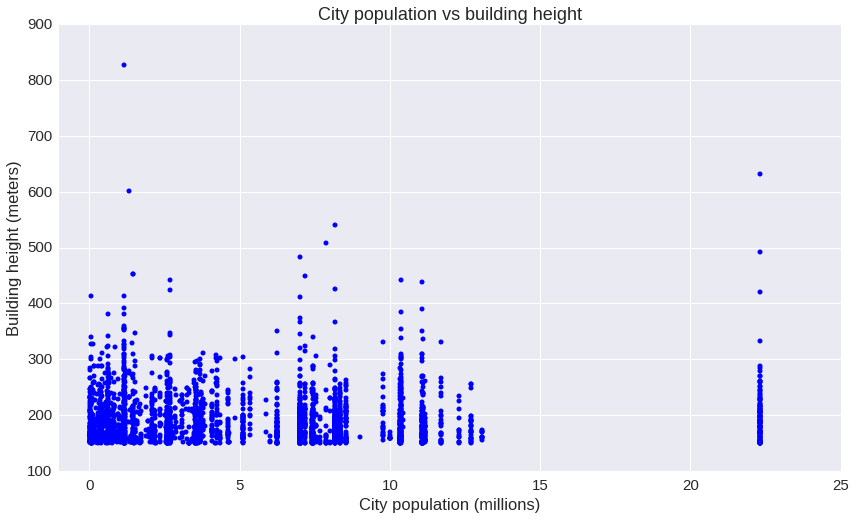

In [203]:
# simple population vs individual building heights
#plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(figsize=(14,8))

ax.plot(df_v1.population/1000000, df_v1.Height_m, 'ob', markersize=5)
ax.set_ylabel('Building height (meters)')
ax.set_xlabel('City population (millions)')
ax.set_title('City population vs building height')
ax.set_xlim(-1, 25)

In [204]:
df_v1.loc[df_v1.population.idxmax(),:]

Rank                              755
Building        21st C entury Mansion
name                         Shanghai
Height_m                          210
Floors                             50
city_lat                      31.2222
city_lon                      121.458
lat                           31.2304
lon                           121.474
population                2.23155e+07
dem                                12
dist_to_city                  1.74426
Name: 186, dtype: object

In [205]:
tallest = df_v1.groupby('name')['Height_m', 'population'].max()
tallest.head()

,Height_m,population
name,,
Abu Dhabi,381.2,603492
Ajman,213.0,226172
Al Fujayrah,170.0,62415
Albany,179.5,97856
Almaty,168.0,2000900


(-1, 25)

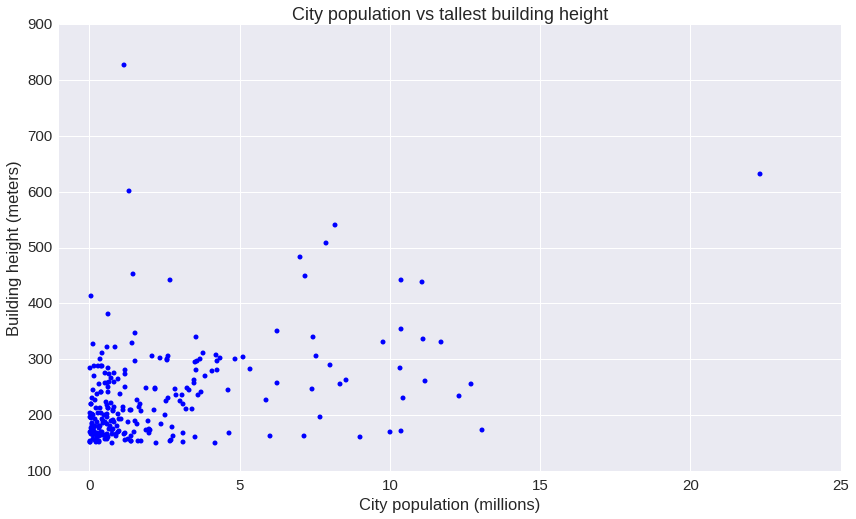

In [206]:
# simple population vs tallest building in city
f, ax = plt.subplots(figsize=(14,8))

ax.plot(tallest.population/1000000, tallest.Height_m, 'ob', markersize=5)
ax.set_ylabel('Building height (meters)')
ax.set_xlabel('City population (millions)')
ax.set_title('City population vs tallest building height')
ax.set_xlim(-1, 25)

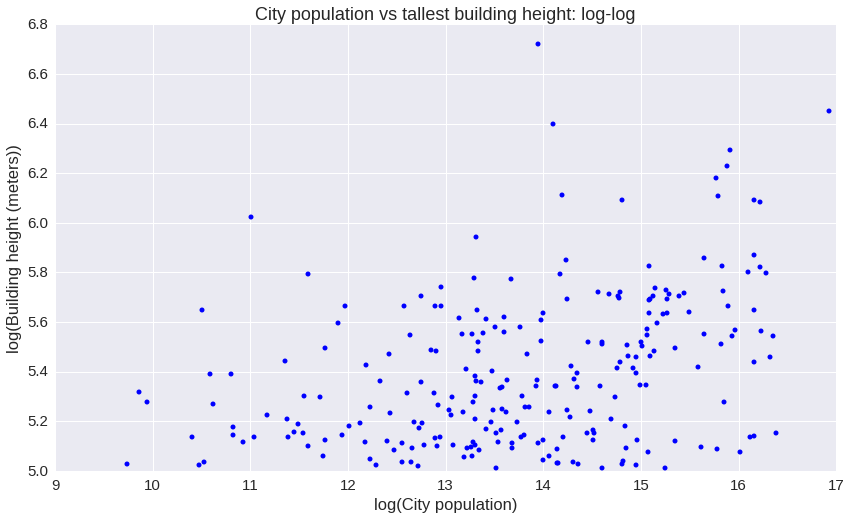

In [207]:
# simple log-log population vs tallest building in city
import numpy as np
plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(figsize=(14,8))

ax.plot(np.log(tallest.population), np.log(tallest.Height_m), 'ob', markersize=5)
ax.set_ylabel('log(Building height (meters))')
ax.set_xlabel('log(City population)')
ax.set_title('City population vs tallest building height: log-log')


In [208]:
# sort by city and building height
df_v1.sort_values(['name', 'Height_m'], inplace=True, ascending=False)
# get up to tallest 5 buildings in each city and aggregate building heights
tallest_5 = df_v1.groupby(['name', 'population']).head(5).\
groupby(['name', 'population'])['Height_m'].agg({'sum', 'mean', 'count'})
tallest_5.rename(columns={'sum': 'TotBldgHeight', 'mean': 'MeanBldgHeight', 'count': 'NumBldgs'}, inplace=True)
tallest_5.reset_index(inplace=True)
tallest_5.head()

,name,population,NumBldgs,TotBldgHeight,MeanBldgHeight
0,Abu Dhabi,603492,5,1644.7,328.94
1,Ajman,226172,1,213.0,213.00
2,Al Fujayrah,62415,2,325.0,162.50
3,Albany,97856,1,179.5,179.50
4,Almaty,2000900,1,168.0,168.00


In [209]:
tallest_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 255
Data columns (total 5 columns):
name              256 non-null object
population        256 non-null float64
NumBldgs          256 non-null int64
TotBldgHeight     256 non-null float64
MeanBldgHeight    256 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 12.0+ KB


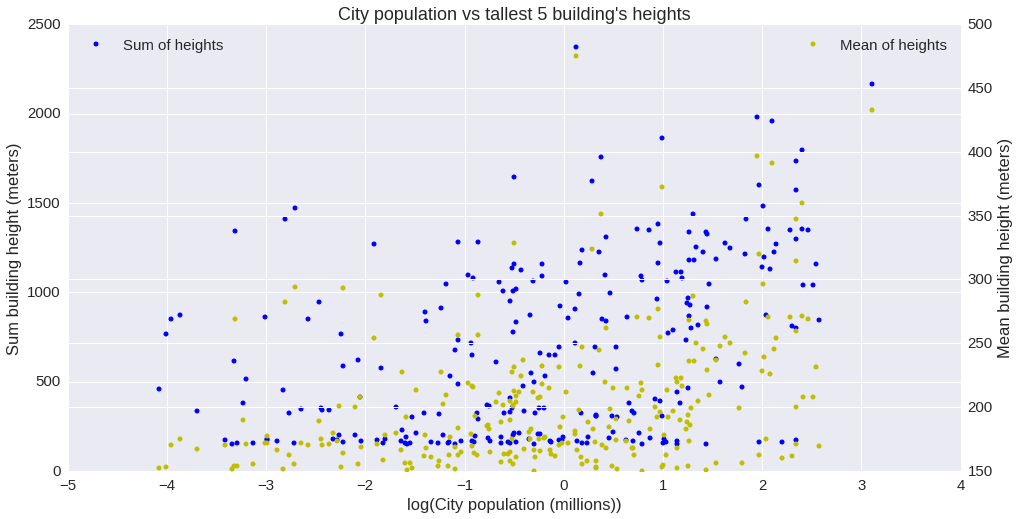

In [210]:
# simple population vs sum of tallest 5 buildings in city
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(16,8))

ax.plot(np.log(tallest_5.population/1000000), tallest_5.TotBldgHeight, 'ob', markersize=5, label='Sum of heights')
ax.set_xlabel('log(City population (millions))')
ax.set_xlim(-1,25)
ax1 = ax.twinx()
ax1.plot(np.log(tallest_5.population/1000000), tallest_5.MeanBldgHeight, 'oy', markersize=5, label='Mean of heights')
ax.set_title('City population vs tallest 5 building\'s heights')
ax.set_ylabel('Sum building height (meters)')
ax1.set_ylabel('Mean building height (meters)')
ax.legend(loc=2)
ax1.legend(loc=1)

In [164]:
import statsmodels.formula.api as smf
#reg_tallest = smf.ols(formula='Height_m ~ population', data=np.log(tallest)).fit()
reg_tallest = smf.ols(formula='TotBldgHeight ~ population', data=tallest_5).fit()
print reg_tallest.summary()

                            OLS Regression Results                            
Dep. Variable:          TotBldgHeight   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     68.37
Date:                Mon, 28 Mar 2016   Prob (F-statistic):           9.18e-15
Time:                        00:24:56   Log-Likelihood:                -1819.9
No. Observations:                 243   AIC:                             3644.
Df Residuals:                     241   BIC:                             3651.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    528.8902     34.935     15.139      0.0

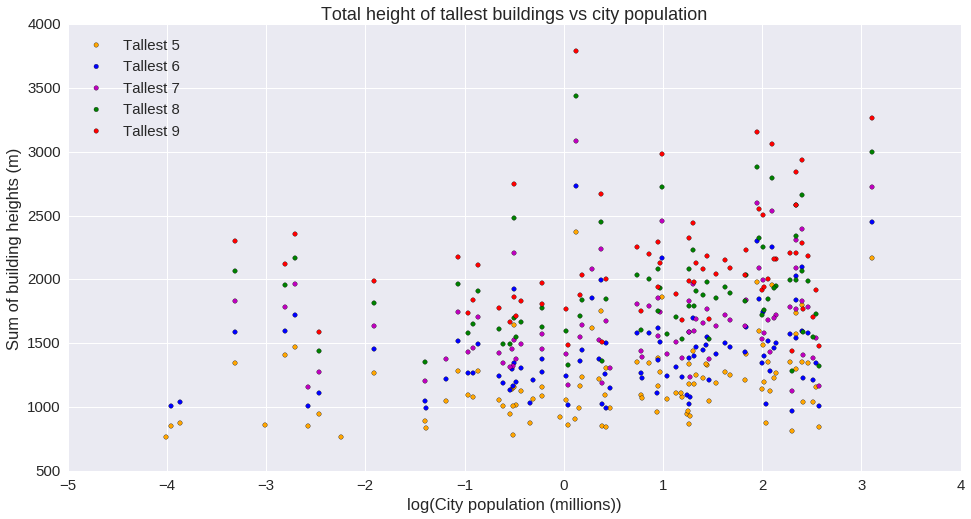

In [223]:
# grab and graph tallest 5-9 iteratively

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(16,8))
ax.set_xlabel('log(City population (millions))')
ax.set_ylabel('Sum of building heights (m)')
ax.set_title('Total height of tallest buildings vs city population')

cols = ['orange', 'b', 'm', 'g', 'r']

for i, n in enumerate(range(5, 10, 1)):
    tn = df_v1.groupby(['name', 'population']).head(n).\
    groupby(['name', 'population'])['Height_m'].agg({'sum', 'mean', 'count'})
    tn.rename(columns={'sum': 'TotBldgHeight', 'mean': 'MeanBldgHeight', 'count': 'NumBldgs'}, inplace=True)
    tn.reset_index(inplace=True)
    tn = tn[tn.NumBldgs==n]
    ax.scatter(np.log(tn.population/1000000), tn.TotBldgHeight, c=cols[i], 
           label='Tallest {}'.format(n))
    
ax.legend(loc=2)

In [224]:
# gradient of buildings from city center
df_grad = df_v1[(df_v1.lat!=0) & (df_v1.lon!=0)]
df_grad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455 entries, 3428 to 1204
Data columns (total 12 columns):
Rank            2455 non-null float64
Building        2455 non-null object
name            2455 non-null object
Height_m        2455 non-null float64
Floors          2455 non-null object
city_lat        2455 non-null float64
city_lon        2455 non-null float64
lat             2455 non-null float64
lon             2455 non-null float64
population      2455 non-null float64
dem             2455 non-null float64
dist_to_city    2455 non-null float64
dtypes: float64(9), object(3)
memory usage: 249.3+ KB


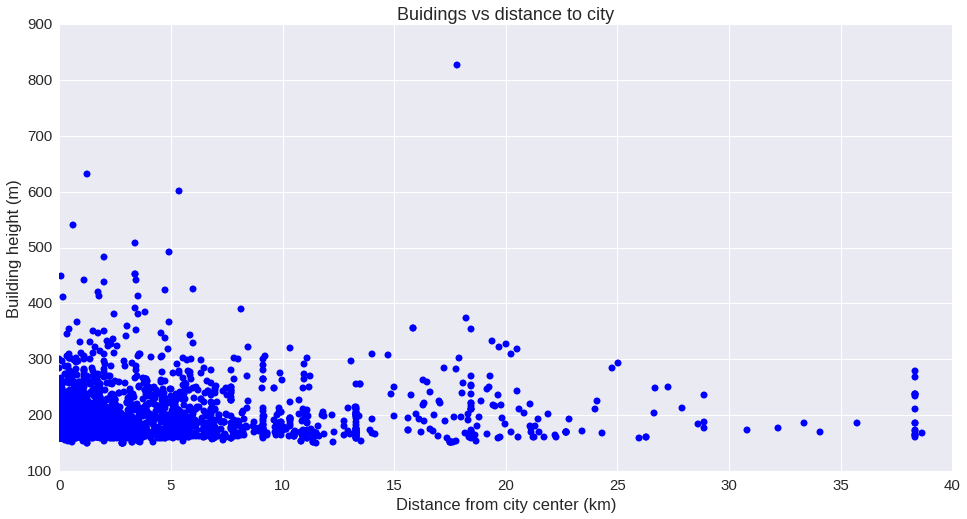

In [232]:
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(16,8))
ax.plot(df_grad.dist_to_city[df_grad.dist_to_city<40], df_grad.Height_m[df_grad.dist_to_city<40], 'ob')
ax.set_ylabel('Building height (m)')
ax.set_xlabel('Distance from city center (km)')
ax.set_title('Buidings vs distance to city')

In [229]:
df_grad[df_grad.dist_to_city>10000]

,Rank,Building,name,Height_m,Floors,city_lat,city_lon,lat,lon,population,dem,dist_to_city
2364,157,Riverside C entury Plaza Main Tower,Wuhu,275.0,66,31.33728,118.37351,33.953349,-117.396156,507524,19,10697.390041
2365,2117,Riverside C entury Plaza Apartment\nTower 1,Wuhu,168.0,48,31.33728,118.37351,33.953349,-117.396156,507524,19,10697.390041
2366,2117,Riverside C entury Plaza Apartment\nTower 2,Wuhu,168.0,48,31.33728,118.37351,33.953349,-117.396156,507524,19,10697.390041
1843,985,ORC 200,Osaka,200.0,51,34.69374,135.50218,36.947040,-82.810716,2592413,24,11118.265146
1386,1135,Times Square Tower D,Chongqing,195.0,41,29.56278,106.55278,40.759011,-73.984472,7457600,225,12195.464427
1403,2139,Times Square Tower C,Chongqing,168.0,39,29.56278,106.55278,40.759011,-73.984472,7457600,225,12195.464427
2948,1009,Palm Springs International C enter\nTower 1,Chengdu,200.0,41,30.66667,104.06667,33.830296,-116.545292,7415590,499,11673.079115
1706,472,The Met,Bangkok,230.6,69,13.75398,100.50144,19.516112,-96.860160,5104476,12,15856.067008


In [230]:
df_grad[(df_grad.dist_to_city>35) & (df_grad.dist_to_city<40)]

,Rank,Building,name,Height_m,Floors,city_lat,city_lon,lat,lon,population,dem,dist_to_city
3053,2121,The Peak,Sydney,168.0,46,-33.86785,151.20732,-33.782345,150.801659,4627345,58,38.659962
76,1425,Etisalat Tower 2,Dubai,185.0,33,25.06570,55.17128,25.264568,55.450423,1137347,3,35.752202
1182,149,World Trade C enter Abu Dhabi - The Offices,Abu Dhabi,278.0,60,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1184,179,Nation Towers Residential Lofts,Abu Dhabi,268.0,64,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1186,398,The Gate Residential Tower 1,Abu Dhabi,238.0,66,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1187,398,The Gate Residential Tower 2,Abu Dhabi,238.0,66,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1188,398,The Gate Residential Tower 3,Abu Dhabi,238.0,66,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1191,445,St. Regis Luxury Hotel,Abu Dhabi,233.2,51,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1194,754,C apital Plaza Residential Towers,Abu Dhabi,210.0,51,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318
1197,1412,ADIA Tower,Abu Dhabi,185.0,40,24.46667,54.36667,24.299174,54.697277,603492,6,38.314318


(-100, 50000)

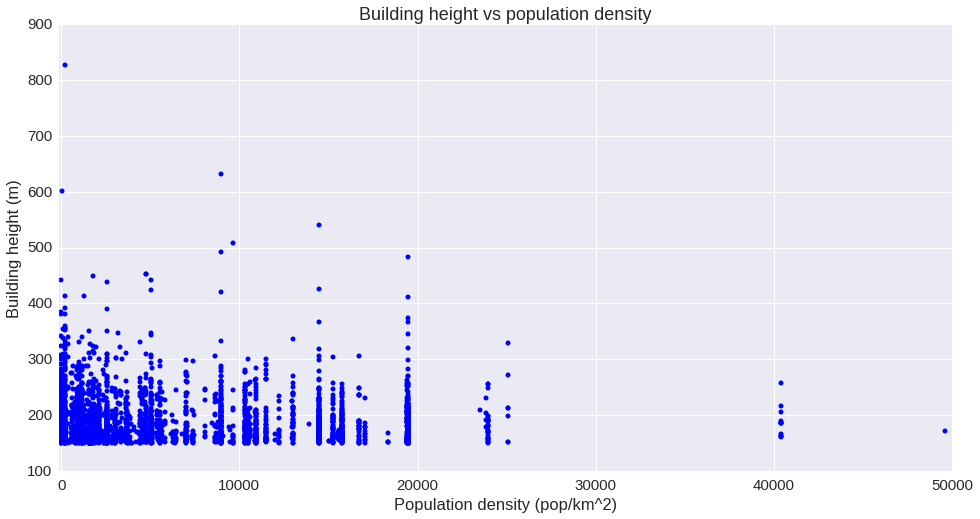

In [265]:
## population density vs building heights
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(16,8))

ax.plot(df_v1.popdens, df_v1.Height_m, 'ob', markersize=5)
ax.set_title('Building height vs population density')
ax.set_ylabel('Building height (m)')
ax.set_xlabel('Population density (pop/km^2)')
ax.set_xlim(-100,50000)